# Data Science Assignment, Veamly

**Start Date** : 2nd January 2019, 10:00 PST

**End Date** : 4th January 2019, 10:00 PST

## Context

You are given the dataset `github_comments.tsv` that carries 4000 comments that were published on pull requests on Github by developer teams.

Here is an explanation of the table columns:
- Comment: the comment made by a developer on the pull request.
- Comment_date: date at which the comment was published
- Is_merged: shows whether the pull request on which the comment was made has been accepted (therefore merged) or rejected.
- Merged_at: date at which the pull request was merged (if accepted).
- Request_changes: each comment is labelled either 1 or 0: if it’s labelled as 1 if the comment is a request for change in the code. If not, it’s labelled as 0.

The goal of this assignment is to dig deeper into the nature of blockers and analyze the requests for change. If possible, try to answer the following questions:
- What are the most common problems that appear in these comments?
- Can we cluster the problems by topic/problem type?
- How long is the resolution time after a change was requested?

These questions are meant to be open ended. The goal is to see how you approach a dataset that contains unstructured data combined with structured data.

## Data exploration

NB : The potential sources of improvements will be marked by : **Potential Improvements**

### Imports

In [178]:
### General ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import warnings
import scipy as sp
from scipy.sparse import coo_matrix, hstack
import ipywidgets as widgets
%matplotlib inline

### Natural Language Processing ###

# WordCloud #
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Tokenizer #
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

# Lematizer #
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Stop Words #
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

# Topic modelling #
from gensim import corpora
import gensim
import pyLDAvis.gensim
from gensim.models import CoherenceModel

# Save models #
import pickle

### Clustering ###
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

### Predicting time before merge ###
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Predicting Code change request ###
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Principal Component Analysis ###
import json
import gzip
from sklearn.decomposition import PCA
from scipy import cluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency, pearsonr
from itertools import combinations
import sys
sys.path.append("lib")
from sklearn import decomposition
from sklearn.manifold import TSNE
from ggplot import *
from sklearn.manifold import TSNE

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maelfabien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maelfabien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [179]:
df = pd.DataFrame.from_csv("github_comments.tsv", sep="\t")

In [180]:
df.head()

,comment,comment_date,is_merged,merged_at,request_changes
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaN,0
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaN,1
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0


In [181]:
df.shape

(4001, 5)

### Data types and Missing values

In [182]:
df.dtypes

comment             object
comment_date        object
is_merged          float64
merged_at           object
request_changes      int64
dtype: object

In [183]:
df.isnull().sum()

comment               0
comment_date          0
is_merged             0
merged_at          2842
request_changes       0
dtype: int64

We observe that 2842 pull requests have *not* lead to a merge.

In [184]:
print("The average rate of pull requests acceptance is : " + str(round((1-df.isnull().sum()['merged_at']/df.shape[0])*100, 4)) + "%")

The average rate of pull requests acceptance is : 28.9678%


However, not all pull requests do actually require a change in the code. Actually, most of the do not. We will take a look at it while exploring the different columns of the data set.

### Prepare the data set

#### Comment and merge dates

As the column comment_date is an object type, we need to set it to a date format.

In [185]:
df['comment_date'] = pd.to_datetime(df['comment_date'])

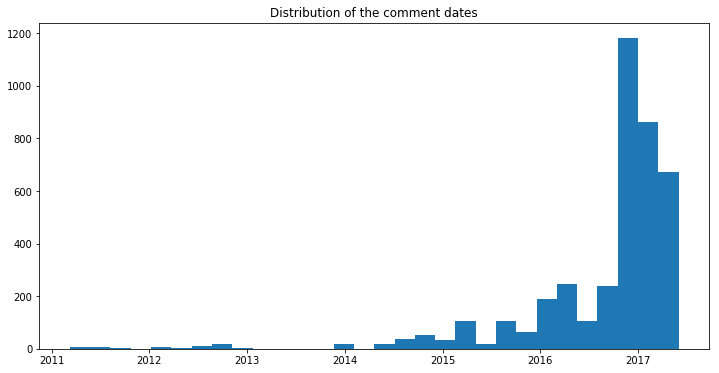

In [186]:
plt.figure(figsize=(12,6))
plt.hist(df['comment_date'], bins=30)
plt.title("Distribution of the comment dates")
plt.show()

The vast majority of messages have been sent recently. We can compare the distributions of the comments dates and the merge date in order to grab first insights.

In [187]:
df['merged_at'] = pd.to_datetime(df['merged_at'])

In [188]:
merging_date = df[df.merged_at.notnull()]['merged_at']

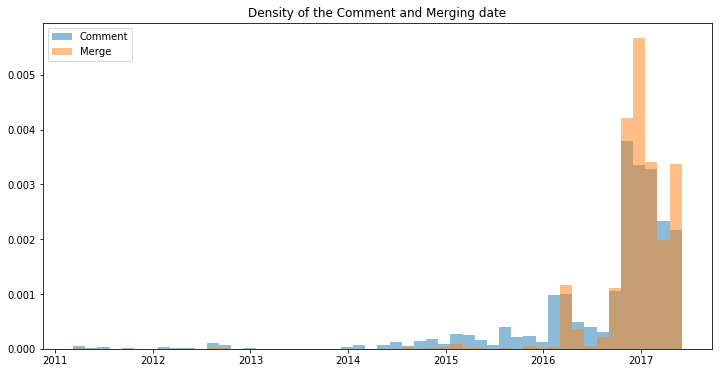

In [189]:
plt.figure(figsize=(12,6))
plt.hist(df['comment_date'], bins = 50, alpha=0.5, label='Comment', normed=True)
plt.hist(merging_date, bins = 50, alpha=0.5, label='Merge', normed=True)
plt.legend(loc='upper left')
plt.title("Density of the Comment and Merging date")
plt.show()

The merge dates are slightly right-shifted compared to the comment dates. This means logically that some time is required before the merge is done. Let's quantify this time for comments that lead to merges :

In [190]:
# Compute the time difference
comment_date = df[df.merged_at.notnull()]['comment_date']
date_difference = merging_date - comment_date

In [191]:
date_difference.describe()

count                       1159
mean      2 days 03:13:55.091458
std      13 days 19:18:28.295276
min          -122 days +04:17:54
25%              0 days 00:17:41
50%              0 days 05:08:10
75%       1 days 09:35:53.500000
max            144 days 03:09:26
dtype: object

On average, the merge date occured 2 days and 3 hours after a comment. However, we do observe a major issue : the minimum is negative, which means that the database contains comments that have been posted after the merge date. This means that those comments were written by developers after the merge as a "thank you" note for example.

#### Request changes

In [192]:
print(str(round(np.mean(df['request_changes']*100),4)) + "% of comments require a change in code")

30.4924% of comments require a change in code


The average acceptation rate among the changes requested is 23%.

In [193]:
len(df[(df['is_merged'] + df['request_changes']) == 2])/len(df[df['request_changes'] == 1])

0.23278688524590163

Among changes that have been requested, the time before merging is defined as the difference between the merge time and the comment time, if the change occured.

In [194]:
df_merged = df[df['is_merged']==1]
df_merged = df_merged[df_merged['request_changes']==1]
date_difference_merge = df_merged['merged_at'] - df_merged['comment_date']
date_difference_merge.describe()

count                        284
mean      3 days 02:02:28.482394
std      17 days 15:43:24.464464
min          -122 days +04:17:54
25%              0 days 02:32:24
50%              0 days 13:58:48
75%       1 days 20:28:46.250000
max            144 days 03:09:26
dtype: object

The average time before merging is indeed longer now (3 days and 2 hours) as code change requests might be slightly more difficult changes to make.

#### Are all comments initial developer comments and not "Thank you" notes ?

First of all, we can compute the time difference, in minutes, between the comment and the merge date.

In [195]:
df['time_diff'] = df['merged_at']- df['comment_date']

The fact that some replies have been written after the latest merge can make us wonder if all comments are initial comments ? Some of them might just be replies.

In [196]:
for index, row in df.iterrows() :
    df.loc[index, 'time_diff'] = df.loc[index, 'time_diff'].total_seconds()/60

In [197]:
df[df['time_diff'] < 0]['comment']

1       omnibus builds are already in pain so merging ...
5            no, that's absolutely the right thing to do.
7                                        Yolo link fixing
14      And now fingers crossed that this doesn't some...
38                                     5.5/5.x: 41087efb6
39                                     5.5/5.x: 8d8438f79
43      Backported to:\r\n* 5.3 by 0d3fb688d2e943f20ed...
44      revert in https://github.com/elastic/logstash/...
351                      Merged. Thanks very much, Rob.\n
584     Thanks for the PR! This is merged into master....
585     Thanks for the PR @eddumelendez! This is now m...
600     Thanks for the PR @vpavic! This is merged into...
603     Thanks for the PR! This is now merged into mas...
621                                             Thanks!\n
622     Sorry about that - was purely by accident! I d...
638     Thanks for the PR @vpavic! This is now merged ...
719     Thanks for the PR @vpavic! This is now merged ...
723     Thanks

As we can see, most of those messages are actually replies of the repository owner on a given comment. It is safe to remove them in order to focus only on messages for which we are able to predict the time before an update is released. One explanation possible is that developers keep all those comments for sprints and release them all at once in a newer version.

In [198]:
df = df.drop(df[df['time_diff']<0].index)

In [199]:
df.shape

(3752, 6)

**Potential improvements** : Change the date of any comment that contains a user id already used. When replying, people generall include a : @username. If we can relate this to the first message that occured, we could avoid duplicates.

#### Add features to the data set

The dates in themselves cannot be exploited in an algorithm. We need to extryct other features from it.

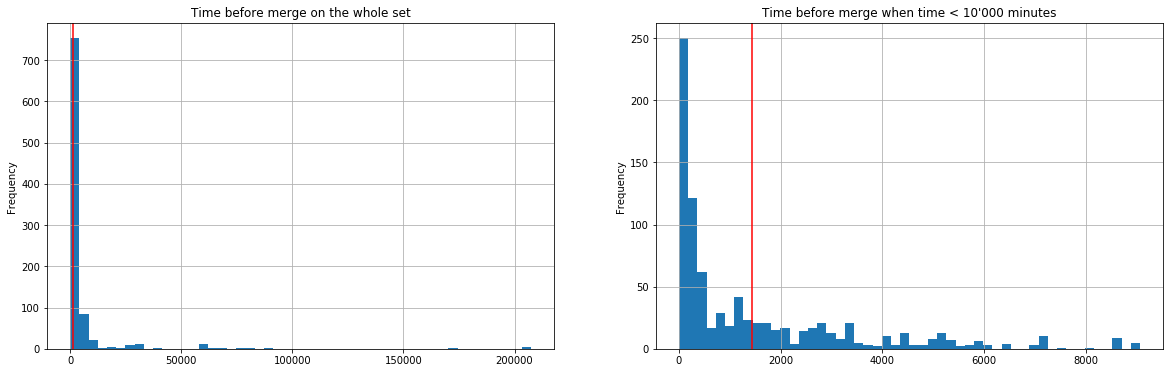

In [200]:
plt.figure(1, figsize=(20,6))

df_full = df[df['time_diff']>0]
#Plot the time difference, and the time difference when < 10000
time_merge = df_full['time_diff']
time_merge_cut = df_full[df_full['time_diff']<10000]['time_diff']

plt.subplot(121)
time_merge.plot.hist(grid=True, bins=50)
plt.title("Time before merge on the whole set")
plt.axvline(x=1440, color = 'red')

plt.subplot(122)
time_merge_cut.plot.hist(grid=True, bins=50)
plt.title("Time before merge when time < 10'000 minutes")
plt.axvline(x=1440, color = 'red')

plt.show()

What features can we extract from the comment_date ?
- Maybe the day of the week tells us something, if the owners of the repository are more active on some days of the week
- Same goes for the week, the month, and the year

In [201]:
for index, row in df.iterrows() :
    df.loc[index, 'year'] = df.loc[index, 'comment_date'].year
    df.loc[index, 'month'] = df.loc[index, 'comment_date'].month
    df.loc[index, 'week'] = df.loc[index, 'comment_date'].day_name() #day of week
    df.loc[index, 'day'] = df.loc[index, 'comment_date'].day
    df.loc[index, 'hour'] = df.loc[index, 'comment_date'].hour

I chose not to include the minute at which the comment is posted since I believe it won't be a relevant feature.

In [202]:
days = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

df['week'] = df['week'].apply(lambda x: days[x])

In [203]:
df.head()

,comment,comment_date,is_merged,merged_at,request_changes,time_diff,year,month,week,day,hour
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaT,0,NaT,2017.0,5.0,0,29.0,10.0
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0,103.233,2017.0,5.0,3,25.0,17.0
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaT,1,NaN,2017.0,5.0,3,25.0,19.0
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0,342.483,2017.0,5.0,1,23.0,22.0
6,^ trailing comma is trolling you,2017-05-23 23:08:46,1.0,2017-05-24 04:40:42,0,331.933,2017.0,5.0,1,23.0,23.0


We can now drop the columns that cannot be used :
- the comment_date
- the merged_at

In [204]:
df = df.drop(['comment_date', 'merged_at'], axis=1)

Did the newly added columns bring some value to our dataset ?

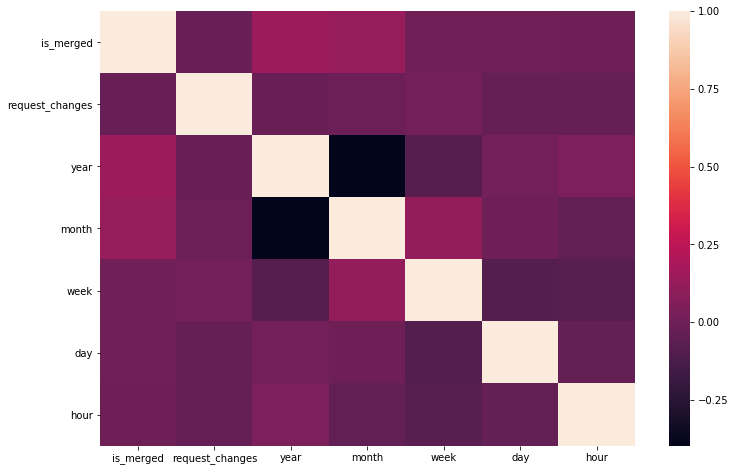

In [205]:
corr = df.drop(['comment'],axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr)
plt.show()

We can take a look at the principal component analysis of the dataset to visualize the numerical information:

Variance explained : 0.9999999999999999


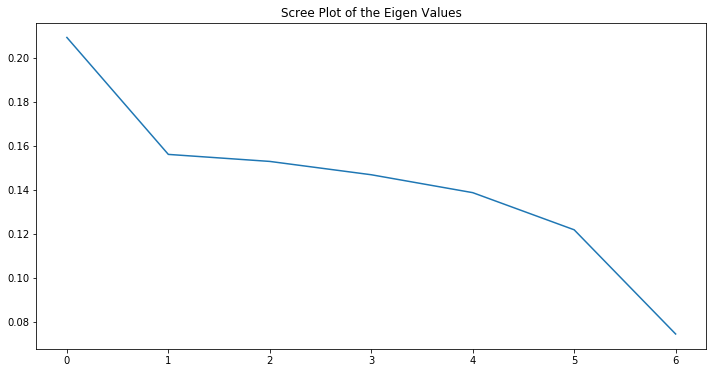

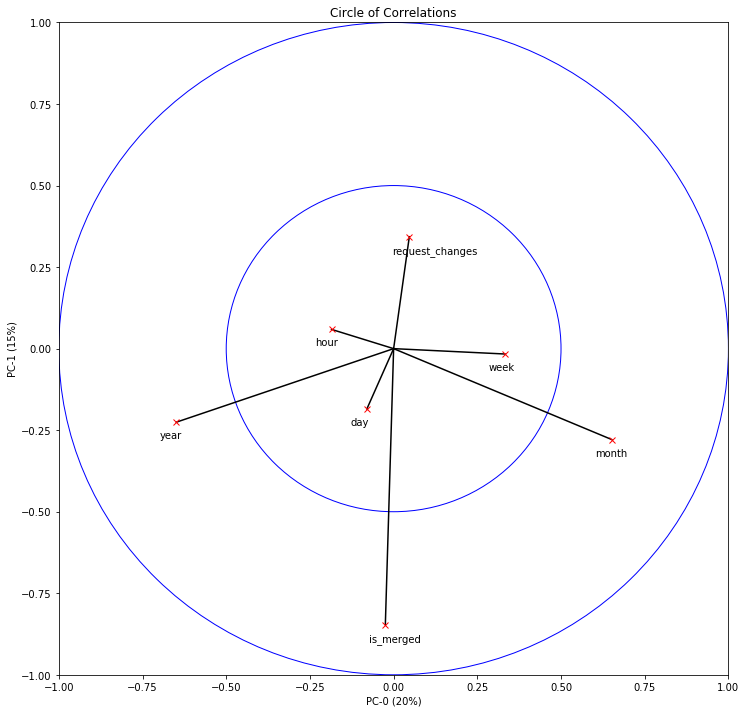

In [206]:
def myPCA(df, clusters=None):
    # Normalize data
    df_norm = (df - (df.mean())) / (df.std())
    # PCA
    pca = PCA(n_components=7)
    global pca_res
    pca_res = pca.fit_transform(df_norm.values)
    print("Variance explained : " + str(pca.explained_variance_ratio_.sum()))
    # Ebouli
    plt.figure(figsize=(12,6))
    ebouli = pd.Series(pca.explained_variance_ratio_)
    ebouli.plot(kind='line', title="Scree Plot of the Eigen Values")
    plt.show()
    
    # Circle of correlations
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(ebouli))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    plt.figure(figsize=(12,12))
    circleOfCorrelations(pc_infos, ebouli)
    plt.show()
    

    return pc_infos, ebouli

def circleOfCorrelations(pc_infos, ebouli):
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='b', fill=False)
    circle2=plt.Circle((0,0),radius=0.5, color='b', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    fig.gca().add_artist(circle2)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x-0.05,y-0.05))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")

pc_infos, ebouli = myPCA(df.drop(['comment', 'time_diff'], axis=1))

The scree plot of the eigen values seems to indicate that there is no real "cliff" in the eigenvalues when assessing the importance of the different dimensions. Moreover, the correlation circle indicates that :
- when the year at which the comment is posted increases, there is more chances that the pull request is merged (seems logic since the project has been more active lately)
- when the day of the month increases (closer to end of the week), we also have more chances to see a merge in the future, although the relationship is weaker.
- The day of the week at which the comment is posted is uncorrelated with the fact of having the pull request merged.
- If a code change is required, the likelihood of merging decreases (which we observed empirically above).

We can take a closer look of the distribution of the moments at which the comments are posted.

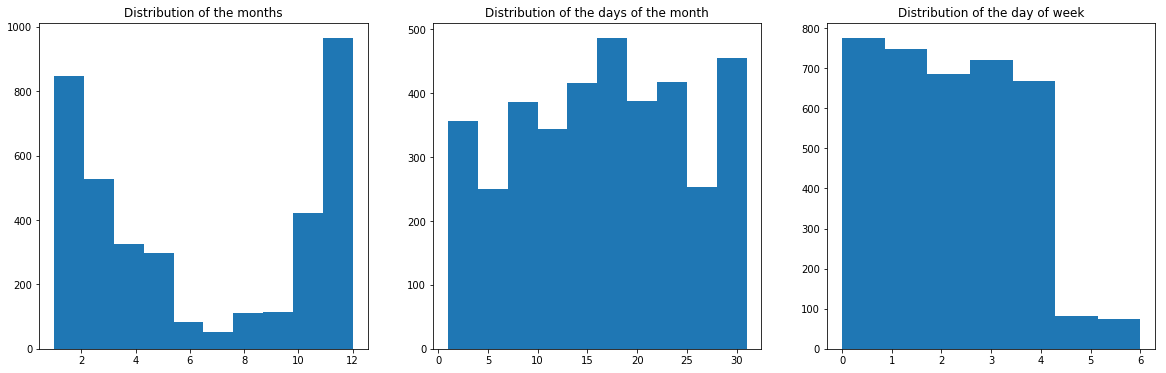

In [207]:
plt.figure(1,figsize=(20,6))

plt.subplot(1,3,1)
plt.hist(df['month'])
plt.title("Distribution of the months")

plt.subplot(1,3,2)
plt.hist(df['day'])
plt.title("Distribution of the days of the month")

plt.subplot(1,3,3)
plt.hist(df['week'], bins=7)
plt.title("Distribution of the day of week")

plt.show()

In the data set :
- most comments are posted between 2016 and end of 2017 as seens above
- most comments are posted in winter period
- most comments are posted at the middle and at the end of the month
- most comments are posted during the week, and much less during the weekend

From this point, the only cleaning task left is to clean the comments. There are several questions we can answer with this data set :
- what are the comments topics ?
- can we identify clusters among those topics ?
- is a comment likely to be a code change request (could be used to pre-check a button when typing a comment) ?
- is a comment likely to lead to a merge ?
- how long will the update of the repo take ?

### Exploration of the comments

In [208]:
comments = df['comment'].tolist()

In [209]:
comments

['@chef/maintainers ',
 '@chef/client-core reviewage (lets not think too hard about the breakpoint resource itself, i just picked it because its the shortest bit of provider code out there)',
 "This blows up 14.04 because allow-downgrades is not supported there, so you'll need to figure out the first versions of ubuntu and debian that can safely support this and conditionally add the flag",
 'I know @lamont-granquist and @thommay  are going to be unhappy about this one. This is absolutely a short term fix until we get choco on the windows jenkins nodes like it was before our system failure.',
 '^ trailing comma is trolling you',
 'Should https://github.com/chef/chef/pull/6156 get added too? i missed adding it to the release notes in my PR',
 "Might also be cool to do this for `node['platform_version']`, in the Ohai loading we could do something like `automatic['platform_version'] = VersionString.new(automatic['platform_version'])`.",
 'The `===` hack might be too much, would be cool if

In [210]:
count = df['comment'].str.split().str.len()

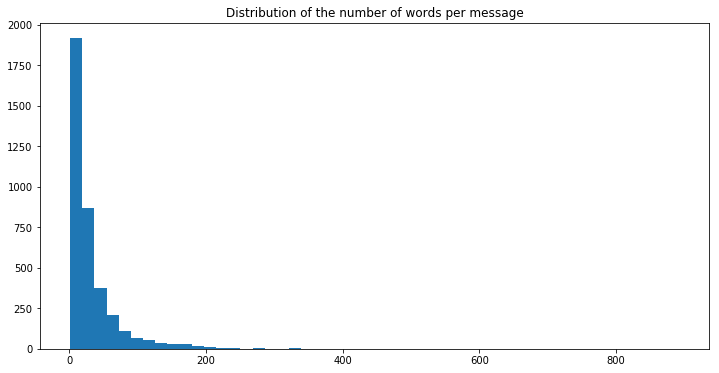

In [211]:
plt.figure(figsize=(12,6))
plt.hist(count, bins=50)
plt.title("Distribution of the number of words per message")
plt.show()

In [212]:
count.describe()

count    3752.000000
mean       31.783582
std        46.047193
min         1.000000
25%         7.000000
50%        18.000000
75%        37.000000
max       892.000000
Name: comment, dtype: float64

On average, the message contain around 31 words. Most messages contain less than 17 words, and some particularly long message contain around 900 words. We should now focus on the content of those message in order to understand the most basic concepts approached in those comments.

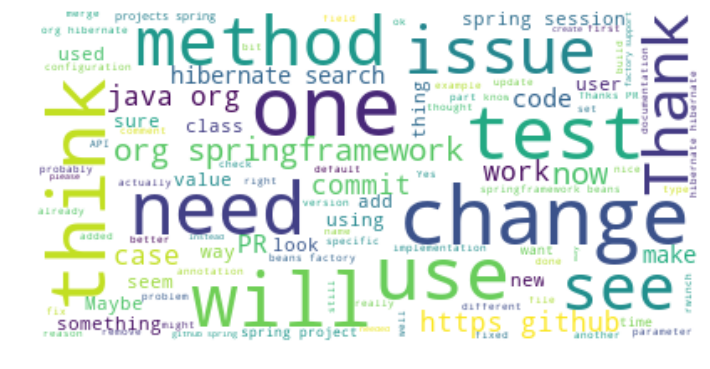

In [213]:
#Remove stopwords using WordCloud built-in stop words
wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=50, max_words=100, background_color="white").generate(''.join(comments))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This Wordcloud allows us to understand the context of the comments we are going to study later on.

### Cleaning the comments

First of all, we need to pre-process the comments content and clean it in order to apply any algorithm :

In [214]:
total_words = {}

#### Replace code-like words

For this step, after exploring the comments, I noticed that there were several issues with expressions like : `\r`, `\t` or `\n`. I decided to replace delete them.

In [215]:
def replace_code(list_message) :
    clean_list = []
    for message in list_message :
        clean_list.append(message.replace('\r', '').replace('\t', '').replace('\n', ''))
    return clean_list

In [216]:
comments = replace_code(comments)

In [217]:
total_words['1-Replace Code'] = len(comments)

#### Tokenize

Then we tokenize the dataset.

In [218]:
def tokenize(list_message):
    clean_list = []
    for message in list_message :
        lda_tokens = []
        tokens = parser(message)
        for token in tokens:
            lda_tokens.append(token.lower_)
        clean_list.append(lda_tokens)
    return clean_list

In [219]:
comments = tokenize(comments)

In [220]:
total_words['2-Tokenize'] = len([item for sublist in comments for item in sublist])

#### Remove small words

We remove all small words (1 characters). The threshold could be adjusted.

In [221]:
def rmv_small(list_message):
    clean_list = []
    for message in list_message :
        clean_message = []
        for word in message :
            if len(word) >= 2 :
                clean_message.append(word)
        clean_list.append(clean_message)
    return clean_list

In [222]:
comments = rmv_small(comments)

In [223]:
total_words['3-Remove Small'] = len([item for sublist in comments for item in sublist])

#### Special Characters cleaning

We will be quite restrictive for this part. Indeed, most of the comments contain code. And syntax is really different for code than it is in natural languages. For this reason, I am removing all words that do contain specific characters that can typically be found in programming languages. There is a longer list also available that commented.

In [224]:
def rmv_text(list_message):
    clean_list = []
    list_rmv = ["'", "`", "-", "+", "=", "@"]
    #list_rmv = ['\r','\n', "'", "/", ":","`", "-", "+", "=", "@", "]", "#", "[", "https://", "http://", "\t"]
    for message in list_message :
        clean_message = []
        for word in message :
            if any(i.isdigit() for i in word) == False and any(j in word for j in list_rmv) == False :
                clean_message.append(word)
        clean_list.append(clean_message)
    return clean_list

In [225]:
comments = rmv_text(comments)

In [226]:
total_words['4-Special Characters'] = len([item for sublist in comments for item in sublist])

#### Remove stopwords

We remove the stop words.

In [227]:
def rmv_stop_words(list_message):
    clean_list = []
    for message in list_message :
        clean_message = []
        for word in message :
            if word not in en_stop :
                clean_message.append(word)
        clean_list.append(clean_message)
    return clean_list

In [228]:
comments = rmv_stop_words(comments)

In [229]:
total_words['5-Stopwords'] = len([item for sublist in comments for item in sublist])

#### Lemmatizing

"The WordNet corpus reader gives access to the Open Multilingual WordNet, using ISO-639 language codes. Morphy uses a combination of inflectional ending rules and exception lists to handle a variety of different possibilities".

In [230]:
def get_lemma(list_message):
    clean_list = []
    for message in list_message :
        clean_message = []
        for word in message :
            lemma = wn.morphy(word)
            if lemma is None:
                clean_message.append(word)
            else:
                clean_message.append(lemma)
        clean_list.append(clean_message)
    return clean_list

In [231]:
comments = get_lemma(comments)

Our data is now ready for further analysis. We can check how many words have been deleted since the first step :

In [232]:
total_words['6-Lemmatizing'] = len([item for sublist in comments for item in sublist])

A great cleaning has been done so far since we kept only 38% of all words. The step that lead to the biggest drop in words is the removal of stop words. This might be too much loss, but the words identified now do pretty much all seem relevant :

In [233]:
total_words

{'1-Replace Code': 3752,
 '2-Tokenize': 148819,
 '3-Remove Small': 116885,
 '4-Special Characters': 109853,
 '5-Stopwords': 59749,
 '6-Lemmatizing': 59749}

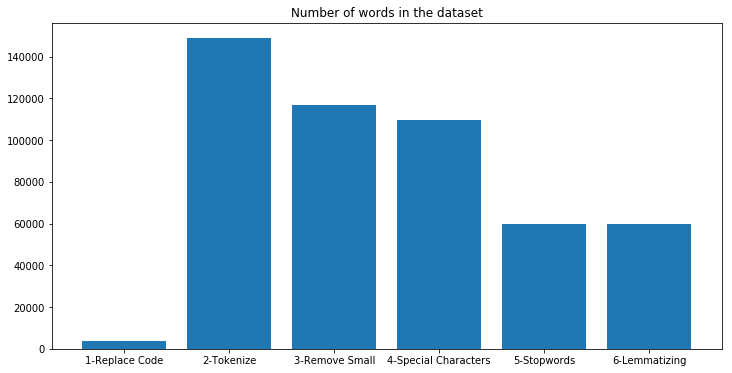

In [234]:
plt.figure(figsize=(12,6))
plt.bar(range(len(total_words)), list(total_words.values()), align='center')
plt.xticks(range(len(total_words)), list(total_words.keys()))
plt.title("Number of words in the dataset")
plt.show()

In [235]:
comments

[['maintainer'],
 ['client',
  'core',
  'reviewage',
  'let',
  'think',
  'hard',
  'breakpoint',
  'resource',
  'pick',
  'short',
  'bit',
  'provider',
  'code'],
 ['blow',
  'allow',
  'downgrade',
  'support',
  'need',
  'figure',
  'first',
  'version',
  'ubuntu',
  'debian',
  'safely',
  'support',
  'conditionally',
  'add',
  'flag'],
 ['know',
  'granquist',
  'going',
  'unhappy',
  'one',
  'absolutely',
  'short',
  'term',
  'fix',
  'get',
  'choco',
  'windows',
  'jenkins',
  'node',
  'like',
  'system',
  'failure'],
 ['trailing', 'comma', 'trolling'],
 ['get', 'add', 'miss', 'add', 'release', 'note', 'pr'],
 ['might', 'also', 'cool', 'ohai', 'loading', 'could', 'something', 'like'],
 ['hack',
  'might',
  'much',
  'would',
  'cool',
  'everyone',
  'else',
  'want',
  'fancy',
  'operator',
  'skip',
  'case',
  'magic'],
 ['yeah', 'probably', 'monkeypatching'],
 ['okay', 'trickery', 'go', 'chef', 'config', 'longer', 'wreck', ':)'],
 ['chefstyle', 'need', 'ca

We can now update the word cloud we have drawn above :

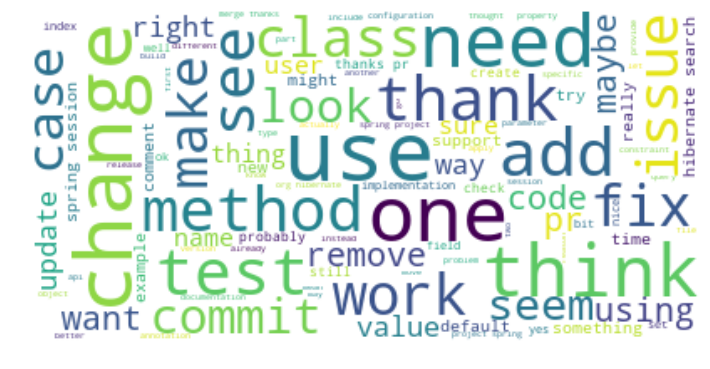

In [236]:
wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=50, max_words=100, background_color="white").generate(' '.join([item for sublist in comments for item in sublist]))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## What are the main topics in the comments ?

In order to answer the question of the main topics that arise in the comments, weneed to do topic modelling. One famous algorithm in the field of natural languageprocessing that allows us to do this is the Latent Dirichlet Allocation (LDA). LDA was developped in 2003 by David Blei, Andrew Ng and Michael Jordan.

We will be relying on gensim, an open source topic modelling in Python, aswell as a more visual librarcy called pyLDAvis.gensim.How does it work ? The model takes a set of words as input. Each word has agiven probability to belong to a certain topic. The LDA should take as an inputthe number of topics that we do expect. We take a collection of documents as aninput, and learn which model describes it best.

LDA produces a matrix with that gives for each word the probability that itbelongs to each topic.

In [237]:
dictionary = corpora.Dictionary(comments)
corpus = [dictionary.doc2bow(text) for text in comments]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

### Apply the LDA

The LDA can be applied on the dictionary defined above.

In [238]:
warnings.filterwarnings('ignore')

NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model12.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.024*"would" + 0.015*"test" + 0.015*"add" + 0.014*"one"')
(1, '0.025*"would" + 0.024*"do" + 0.016*"index" + 0.015*"string"')
(2, '0.016*"look" + 0.016*"like" + 0.011*"see" + 0.011*"test"')
(3, '0.039*"please" + 0.026*"jenkins" + 0.021*"retest" + 0.017*"session"')
(4, '0.039*"test" + 0.032*"ok" + 0.030*"add" + 0.020*"one"')
(5, '0.085*"thanks" + 0.069*"merge" + 0.037*"pr" + 0.031*"fix"')
(6, '0.029*"use" + 0.020*":)" + 0.015*"one" + 0.014*"constraint"')
(7, '0.019*"hibernate" + 0.018*"test" + 0.017*"need" + 0.015*"change"')
(8, '0.032*"spring" + 0.028*"request" + 0.021*"update" + 0.021*"push"')
(9, '0.066*"spring" + 0.030*"session" + 0.027*"       " + 0.019*"project"')
(10, '0.015*"use" + 0.014*"change" + 0.013*"flush" + 0.012*"need"')
(11, '0.016*"use" + 0.012*"commit" + 0.012*"would" + 0.011*"type"')


The "print(topic)" show the topics and the "friend" that are the words related to the topic.

There are more graphical ways to reprensent those topics and show a more complete list of "friends" on each topic.

### Visualize the topics 

In [239]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model12.gensim')

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

How to interpret this graph ?
- the top 30 most salient terms is a measure of how likely is a word going to predict a given topic. It is a measure of importance in some sens.
- we can see the topics by clicking on each circle. The size of each circle shows the importance of the topic in the data set.
- the relevance of the word is a weighted average probability of observing the word given the topic

The topics are projected using a Principal Coordinates Analysis (PCoA). We can identify several clusters on the PCoA plot. However, all the most important topics are more or less located on the same region of the graph. The important topics we can extract from this graph are :
- an issue with spring session
- developers discussion Jiras and planning
- some issues with a file and collections
- a bug with some module metadata
- ...

**Potential improvements** : As we can see here, most part of the time, the most common words could also be deleted. This would required estimating overall document frequency and deleting the word if it is among the X% most popular words. This process is also done in the TF-IDF (see later) by giving a smaller weight to such words.

Is our model coherent ?

In [240]:
coherence_model_lda = CoherenceModel(model=lda, texts=comments, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.47831255604972744


**Potential improvements** : The coherence highly depends on the intial number of topics chosen. One could try several models with several number of topics in order to find the optimal number of clusters.

## Can we cluster the problems by topic/problem type?

The clustering approach can typically be solved by :
- projecting our corpus into a vector space using TF-IDF
- applying a K-Means clustering algorithm
- and using a dimension reduction algorithm in order to project the dimension of a 2D plane

### Term Frequency - Inverse Document Frequency

**Step 1** : Count each word occurrence by document, and put it in a term frequency matrix.

**Step 2** : Apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

In [241]:
def dummy_fun(doc):
    return doc

In [242]:
tfidf = TfidfVectorizer(
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None, use_idf=True)  

tfidf_matrix = tfidf.fit_transform(comments) #fit the vectorizer to synopses

In [243]:
tfidf_matrix

<3752x5854 sparse matrix of type '<class 'numpy.float64'>'
	with 50646 stored elements in Compressed Sparse Row format>

There is overall 5854 words of vocabulary according to our cleaning rules in the dataset.

In [244]:
terms = tfidf.vocabulary_
terms

{'maintainer': 3150,
 'client': 841,
 'core': 1120,
 'reviewage': 4479,
 'let': 3023,
 'think': 5250,
 'hard': 2257,
 'breakpoint': 638,
 'resource': 4419,
 'pick': 3904,
 'short': 4765,
 'bit': 574,
 'provider': 4108,
 'code': 855,
 'blow': 590,
 'allow': 242,
 'downgrade': 1485,
 'support': 5089,
 'need': 3439,
 'figure': 1882,
 'first': 1925,
 'version': 5641,
 'ubuntu': 5449,
 'debian': 1263,
 'safely': 4538,
 'conditionally': 979,
 'add': 174,
 'flag': 1938,
 'know': 2957,
 'granquist': 2185,
 'going': 2173,
 'unhappy': 5497,
 'one': 3589,
 'absolutely': 135,
 'term': 5189,
 'fix': 1931,
 'get': 2094,
 'choco': 789,
 'windows': 5752,
 'jenkins': 2883,
 'node': 3480,
 'like': 3043,
 'system': 5130,
 'failure': 1832,
 'trailing': 5363,
 'comma': 907,
 'trolling': 5395,
 'miss': 3315,
 'release': 4317,
 'note': 3502,
 'pr': 3971,
 'might': 3283,
 'also': 258,
 'cool': 1116,
 'ohai': 3578,
 'loading': 3078,
 'could': 1135,
 'something': 4866,
 'hack': 2233,
 'much': 3372,
 'would': 57

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus. For a matter of coherence, the number of clusters will be the number of topics defined above. 

In [245]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  9.47000914e-01],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  9.82425558e-01],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  8.73842113e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  9.47000914e-01,  9.82425558e-01, ...,
         8.73842113e-01,  1.00000000e+00,  0.00000000e+00]])

### KMeans clustering

We can then apply a clustering algorithm in order to understand the structure of the datas. A dimension reduction using PCA or Multidimensional Scaling will also allow us to plot the data on a 2D graph and visualize the clusters. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares.

In [246]:
num_clusters = NUM_TOPICS

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [247]:
#Clusters labels
clusters = km.labels_.tolist()

In [248]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
#Create a vocabulary frame to attach an observation to a word
vocab_frame = [item for sublist in comments for item in sublist]

In [249]:
list_words = []
for i in range(num_clusters):
    list_friends = []
    print()
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        list_friends.append(vocab_frame[ind])
        print(' %s' % vocab_frame[ind], end=',')
    list_words.append(list_friends)


Cluster 0 words: much, excellent, fields, branch, update, cookbook,
Cluster 1 words: rebase, update, fields, reasoning, path, os,
Cluster 2 words: details, could, fields, documentation, make, think,
Cluster 3 words: new, thanks, path, find, os, fields,
Cluster 4 words: much, contributing.md#sign, mean, path, fields, resource,
Cluster 5 words: excellent, fields, agreement, path, tag, thanks,
Cluster 6 words: cookbook, fields, documentation, app, details, path,
Cluster 7 words: lot, support, want, remark, try, email,
Cluster 8 words: pr, could, think, soon, sign, make,
Cluster 9 words: branch, resource, pousse, details, mean, documentation,
Cluster 10 words: need, update, explain, review, pr, version,
Cluster 11 words: least, equal, good, could, change, version,

### Cluster representation

An efficient (but computationally heavy) algorithm for clustering is the T-Distributed Stochastic Neighbouring Entities (t-SNE). It looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions.

In [250]:
pos = TSNE(n_components=2, verbose=1).fit_transform(dist)
#The xs and ys will be the positions on the plot
xs, ys = pos[:, 0], pos[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3752 samples in 0.478s...
[t-SNE] Computed neighbors for 3752 samples in 90.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3752
[t-SNE] Computed conditional probabilities for sample 2000 / 3752
[t-SNE] Computed conditional probabilities for sample 3000 / 3752
[t-SNE] Computed conditional probabilities for sample 3752 / 3752
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.061775
[t-SNE] Error after 1000 iterations: 2.027062


In [251]:
clusters = km.labels_.tolist()

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#FF69B4', 
                  6: '#FFA07A',
                  7: '#FF0000', 
                  8: '#FFFF00', 
                  9: '#800000', 
                  10: '#00008B', 
                  11: '#008080',       
                 }

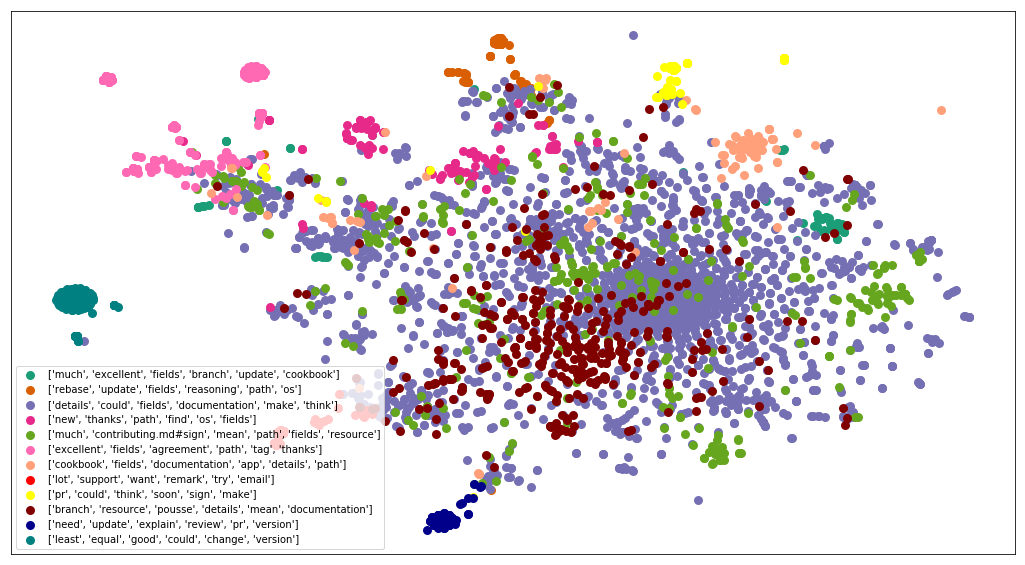

In [252]:
df_mds = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

# Group by cluster
groups = df_mds.groupby('label')

fig, ax = plt.subplots(figsize=(18, 10)) # set size

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=9, 
            label=list_words[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

plt.show() #show the plot

The clusters are now visible :
- we can observe some relevant clusters within the group
- a 2D space might not be enough, a 3D one could bring additional information
- there is a cluster much larger than others
- some clusters are splitted on the map
- some clusters are really well identified
- the clustering could be improved by :
    - selecting more carefully the number of clusters
    - cleaning better the input datas

I have also tried to apply a threshold to display the clusters
````
threshold = 0.5
_idx = np.amax(dist, axis=1) > threshold  # idx of doc that above the threshold
dist2 = dist[_idx]
````
But the improvement is not significant.

**Potential improvements** : A 3D representation could allow a better view of the clusters.

Alright, so far, we have already answered two questions out of the 5 we were initially considering :
- **what are the comments topics ?**
- **can we identify clusters among those topics ?**
- is a comment likely to be a code change request (could be used to pre-check a button when typing a comment) ?
- is a comment likely to lead to a merge ?
- how long will the update of the repo take ?

## Additional question : Is a comment likely to lead to a merge ?

Let's update the comments with the cleaner version :

In [253]:
new_list = []
for comment in comments :
    new_list.append(' '.join(comment))

In [254]:
df = df.reset_index().drop(['index'], axis=1)

In [255]:
df['comment'] = pd.DataFrame(new_list)

In [256]:
df.shape

(3752, 9)

In [257]:
df.head()

,comment,is_merged,request_changes,time_diff,year,month,week,day,hour
0,maintainer,0.0,0,NaT,2017.0,5.0,0,29.0,10.0
1,client core reviewage let think hard breakpoin...,1.0,0,103.233,2017.0,5.0,3,25.0,17.0
2,blow allow downgrade support need figure first...,0.0,1,NaN,2017.0,5.0,3,25.0,19.0
3,know granquist going unhappy one absolutely sh...,1.0,0,342.483,2017.0,5.0,1,23.0,22.0
4,trailing comma trolling,1.0,0,331.933,2017.0,5.0,1,23.0,23.0


We won't need the time_diff since it is typically an information to which we have access only later on.

In [258]:
df_merge = df.drop(['time_diff'], axis=1)

### Build the data set

In order to build the data set, we concatenate the count vectorizer with the features.

In [259]:
vectorizer_merge = CountVectorizer(binary=True)
X = vectorizer_merge.fit_transform(df_merge['comment'])

In [260]:
X = hstack([X,df_merge[['request_changes', 'year', 'month', 'week', 'day', 'hour']]])

In [261]:
y = df_merge["is_merged"].values.astype(np.float32) 

### Train a model

We then apply a train test split with 20% on the test size.

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### KNN Classifier

In [263]:
knn_acc = []
for k in range(1,30) :
    knn_merge = KNeighborsClassifier(k)
    knn_merge.fit(X_train, y_train) 
    knn_merge_pred = knn_merge.predict(X_test)
    knn_acc.append(accuracy_score(knn_merge_pred, y_test))

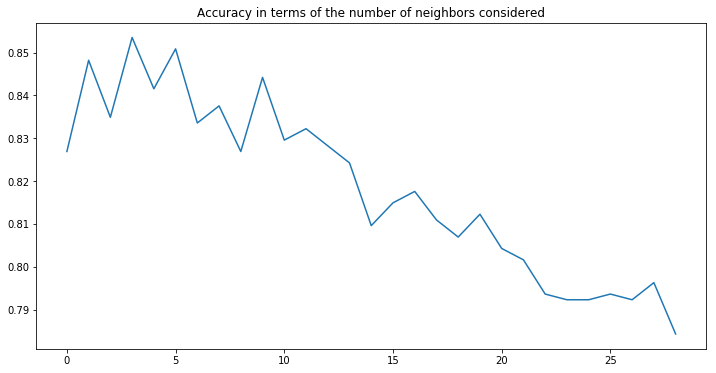

In [264]:
plt.figure(figsize=(12,6))
plt.plot(knn_acc)
plt.title("Accuracy in terms of the number of neighbors considered")
plt.show()

In [265]:
knn_merge = KNeighborsClassifier(4)
knn_merge.fit(X_train, y_train) 
knn_merge_pred = knn_merge.predict(X_test)
accuracy_score(knn_merge_pred, y_test)

0.8535286284953395

The accuracy is optimal with 4 neighbors.

#### Random Forest Classifier

In [266]:
rf_merge = RandomForestClassifier(n_estimators=100)
rf_merge.fit(X_train, y_train) 
rf_merge_pred = rf_merge.predict(X_test)
accuracy_score(rf_merge_pred, y_test)

0.8308921438082557

The accuracy of the KNN seems higher. We are able to predict quite successfully with a KNN whether a comment will lead to a merge or not. Recall that around 30% of the comment a code change requests. Therefore, we perform better than by simply predicting 0 at each time.

**Potential Improvements** : Hyperparameter tuning to improve the accuracy.

**NB** : We only considered a Bag-Of-Word approach here using the CountVectorizer of SkLearn. It is also important to try the TF-IDF method to compare the results.

In [267]:
vectorizer_tf_merge = TfidfVectorizer()
X = vectorizer_tf_merge.fit_transform(df_merge['comment'])

In [268]:
X = hstack([X,df_merge[['request_changes','year', 'month', 'week', 'day', 'hour']]])

In [269]:
X.shape

(3752, 5251)

In [270]:
rf_merge = RandomForestClassifier(n_estimators=100)
rf_merge.fit(X_train, y_train) 
rf_merge_pred = rf_merge.predict(X_test)
accuracy_score(rf_merge_pred, y_test)

0.844207723035952

In this case, we loose accuracy. The change in accuracy is not massive. One major issue with our approach is that we face a wide matrix that has more dimensions than observations. As long as we do not have more trainign samples, we might want to cinsider dimension reduction techniques. 

### Dimension redution

First of all, let's try a classic approach using PCA :

In [271]:
def myPCA(df, clusters=None):
    # Normalize data
    df = pd.DataFrame(df.toarray())
    df_norm = (df - (df.mean())) / (df.std())
    # PCA
    pca = PCA(n_components=10)
    pca_res = pca.fit_transform(df_norm.values)
    print("Variance explained : " + str(pca.explained_variance_ratio_.sum()))
    # Ebouli
    plt.figure(figsize=(12,6))
    ebouli = pd.Series(pca.explained_variance_ratio_)
    ebouli.plot(kind='line', title="Scree Plot of the Eigen Values")
    plt.show()

Variance explained : 0.03884121983051083


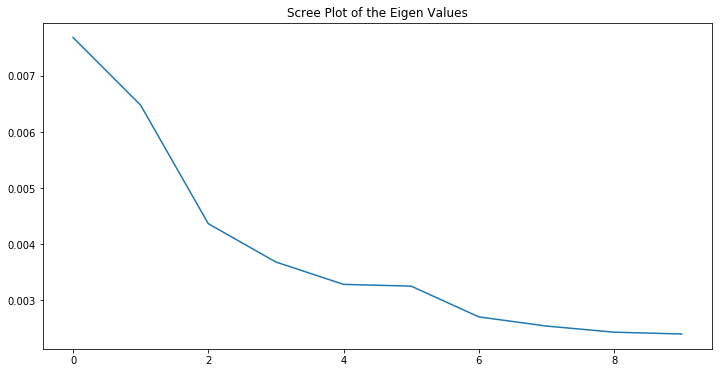

In [272]:
myPCA(X)

As we might have expected, the PCA performs poorly on such sparse matrix. Let's move on to a much more adapted dimension reduction technique : the Latent semantic indexing (LSI). It is an indexing and retrieval method that uses a truncated singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. 

To avoid giving too much weight to the meta datas (date of the comment), we will include the columns before the dimension reduction.

In [273]:
vectorizer_tf_merge = TfidfVectorizer()
X = vectorizer_tf_merge.fit_transform(df_merge['comment'])
svd_merge = TruncatedSVD(n_components=30, n_iter=7, random_state=42)

X_new = hstack([X,df_merge[['request_changes', 'year', 'month', 'week', 'day', 'hour']]])
X_new = svd_merge.fit_transform(X_new)  

In [274]:
y = df_merge["is_merged"].values.astype(np.float32) 

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)

In [276]:
knn_acc = []
for k in range(1,30) :
    knn_merge = KNeighborsClassifier(k)
    knn_merge.fit(X_train, y_train) 
    knn_merge_pred = knn_merge.predict(X_test)
    knn_acc.append(accuracy_score(knn_merge_pred, y_test))

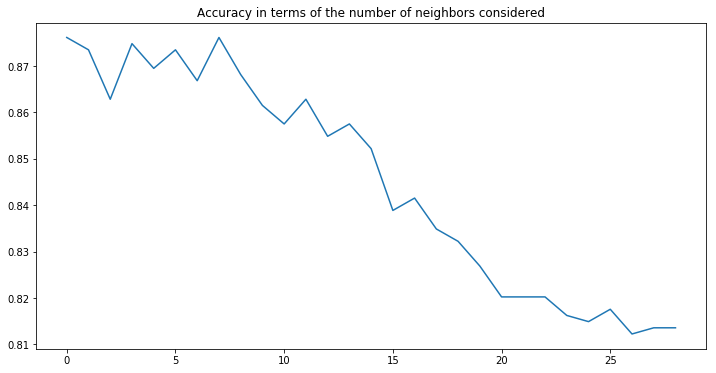

In [277]:
plt.figure(figsize=(12,6))
plt.plot(knn_acc)
plt.title("Accuracy in terms of the number of neighbors considered")
plt.show()

The accuracy seems more sensitive to the number of neighbors, which seems logic since neighbors are now projected on a smaller dimension plane. The accuracy however improves for k = 8 neighbors.

In [278]:
knn_merge = KNeighborsClassifier(8)
knn_merge.fit(X_train, y_train) 
knn_merge_pred = knn_merge.predict(X_test)
accuracy_score(knn_merge_pred, y_test)

0.8761651131824234

## How long is the resolution time after a change was requested?

### If a request is accepted, how long will it take before merge ?

In [279]:
df.head()

,comment,is_merged,request_changes,time_diff,year,month,week,day,hour
0,maintainer,0.0,0,NaT,2017.0,5.0,0,29.0,10.0
1,client core reviewage let think hard breakpoin...,1.0,0,103.233,2017.0,5.0,3,25.0,17.0
2,blow allow downgrade support need figure first...,0.0,1,NaN,2017.0,5.0,3,25.0,19.0
3,know granquist going unhappy one absolutely sh...,1.0,0,342.483,2017.0,5.0,1,23.0,22.0
4,trailing comma trolling,1.0,0,331.933,2017.0,5.0,1,23.0,23.0


We can drop the column "is_merged" since we will only focus on pull requests that will be merged.

In [280]:
df_time = df.drop(['is_merged'], axis=1)[df['time_diff']>0]

In [281]:
df_time.shape

(910, 8)

### Build the data set

As previously, we apply a Count Vectorizer.

In [305]:
vectorizer_time = CountVectorizer(binary=True)
X = vectorizer_time.fit_transform(df_time['comment'])

In [306]:
X = hstack([X,df_time[['request_changes', 'year', 'month', 'week', 'day', 'hour']]])

In [307]:
y = df_time["time_diff"].values.astype(np.float32) 

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Nearest Neighbors Regressor

In [309]:
knn_acc = []
for k in range(1,30) :
    knn_time = KNeighborsRegressor(k)
    knn_time.fit(X_train, y_train) 
    knn_time_pred = knn_time.predict(X_test)
    knn_acc.append(r2_score(y_test, knn_time_pred))

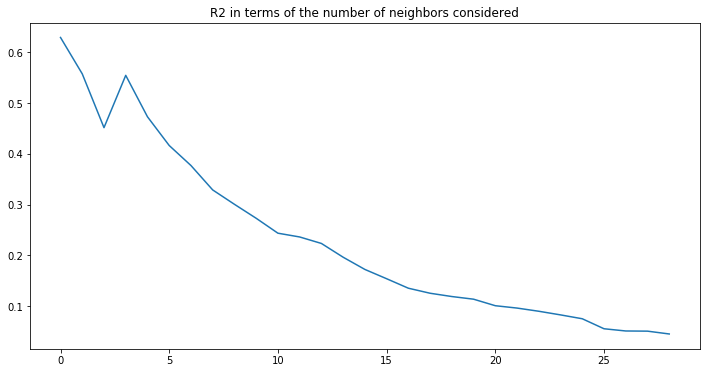

In [310]:
plt.figure(figsize=(12,6))
plt.plot(knn_acc)
plt.title("R2 in terms of the number of neighbors considered")
plt.show()

In [313]:
knn_time = KNeighborsRegressor(2)
knn_time.fit(X_train, y_train) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [314]:
y_time_pred = knn_time.predict(X_test)
r2_score(y_test, y_time_pred)

0.5573623564255173

#### Random Forest Regressor

In [315]:
rf_time = RandomForestRegressor(n_estimators = 100)
rf_time.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [316]:
y_time_pred = rf_time.predict(X_test)
r2_score(y_test, y_time_pred)

0.652977518031728

We are able to explain around 65% of the variance of the problem. 

**Potential improvements** : Hyperparameter tuning to improve the R2.

### Dimension reduction

We can apply the LSA dimension reduction which is a truncated SVD to represent it in 2 dimensions.

In [317]:
vectorizer_tf_time = TfidfVectorizer()
X = vectorizer_tf_time.fit_transform(df_time['comment'])

svd_time = TruncatedSVD(n_components=60, n_iter=7, random_state=42)
X_new = hstack([X,df_time[['request_changes', 'year', 'month', 'week', 'day', 'hour']]])
X_new = svd_time.fit_transform(X_new)  

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)

In [319]:
knn_acc = []
for k in range(1,30) :
    knn_time = KNeighborsRegressor(k)
    knn_time.fit(X_train, y_train) 
    knn_time_pred = knn_time.predict(X_test)
    knn_acc.append(r2_score(y_test, knn_time_pred))

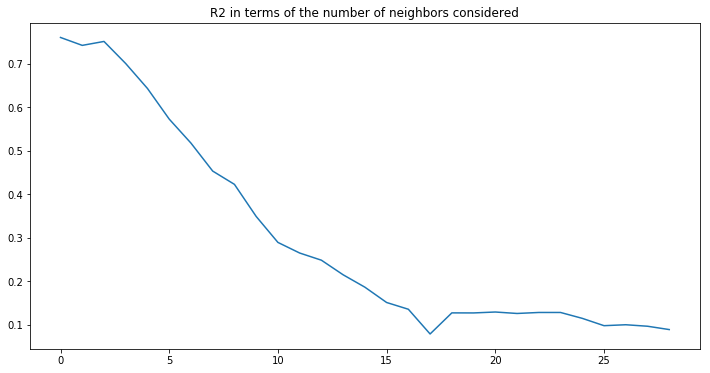

In [320]:
plt.figure(figsize=(12,6))
plt.plot(knn_acc)
plt.title("R2 in terms of the number of neighbors considered")
plt.show()

The dimension reduction highly improves the KNN classifier.

In [321]:
knn_time = KNeighborsRegressor(3)
knn_time.fit(X_train, y_train) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [322]:
y_time_pred = knn_time.predict(X_test)
r2_score(y_test, y_time_pred)

0.7513453931848447

## Wrapping it up

Even though the whole model can highly be improved, I chose to present a quick summary of the questions covered using the models we have trained above. It works the following way :
- the user types in a sentence
- the algorithm with pre-process and clean the sentence
- using the above trained models, we predict :
    - if the comment requires a code change
    - if the comment will lead to a merge
    - how long it will take before the update of the code

In [323]:
def predictions(message, change_needed, year, month, week, day, hour) :
    
    #Replace code-like expressions
    message = message.replace('\r', '').replace('\t', '').replace('\n', '')
    
    #tokenize
    lda_tokens = []
    tokens = parser(message)
    for token in tokens:
        lda_tokens.append(token.lower_)

    #Special characters
    list_rmv = ["'", "`", "-", "+", "=", "@"]
    clean_message = []
    for token in lda_tokens :
        if any(i.isdigit() for i in token) == False and any(j in token for j in list_rmv) == False :
            clean_message.append(token)
    
    #Stop Words
    clean_stop = []
    for token in clean_message :
        if token not in en_stop :
            clean_stop.append(token)
    
    #Lemmatizing
    final_list = []
    for token in clean_stop :
        lemma = wn.morphy(token)
        if lemma is None:
            final_list.append(token)
        else:
            final_list.append(lemma)
    
    #Back to a string
    final_string = ' '.join(final_list)
    print("##### The clean version of your message is : #####")
    print(final_string)
    
    # Predict if merge
    X_merge = vectorizer_tf_merge.transform([final_string])
    X_merge = hstack([X_merge,1,year, month, week, day, hour])
    X_merge = svd_merge.transform(X_merge)  
    knn_pred_merge = knn_merge.predict(X_merge)
    print("##### The comment is likely to lead to a merge : #####")
    print(bool(knn_pred_merge[0]))
    
    # Predict time needed
    X_time = vectorizer_tf_time.transform([final_string])
    X_time = hstack([X_time, change_needed, year, month, week, day, hour])
    X_time = svd_time.transform(X_time)  
    knn_pred_time = knn_time.predict(X_time)
    print("##### If a change occurs, estimated time before update is : #####")
    print(str(round(knn_pred_time[0]/60,2)) + " hours")

In [324]:
predictions("Thanks for letting us know. Are you using version 3.5 or the latest release ? Is there a version conflict with your Java driver ?", 1, 2018, 10, 1, 20, 12)

##### The clean version of your message is : #####
thanks letting us know . using version latest release ? version conflict java driver ?
##### The comment is likely to lead to a merge : #####
False
##### If a change occurs, estimated time before update is : #####
10.9 hours


## Conclusion

The key elements we have covered in this assignment are  :
- it is possible to extract topics from the comments, although is requires a lot of iterations to identify the right amount of topics to focus on (or additional knowledge on how many github projects have been included here)
- it is possible to build clusters, but the results are not so satisfying. Additional work is required here
- it is possible to forecast if a comment will lead to a merge with a decent accuracy
- it is possible to estimate the time required before the update of the code is done, but the R2 remains low

However :
- the final prediction seems to depend quite a lot on the time at which the comment was posted, espacially the hour
- this is quite logic since most comments are answered within 1 or 2 working days, and if a comment is posted right before night time, it directly adds a whole night of time to answer
- our model is too sensitive to hyperparameters chosen above, but especially to some keywords used that influence the dimension reduction
- we would require much more training samples in order to provide a better model
- more training samples would also allow deep learning approaches to be developed

## Sources

During the preparation of this notebook, the following sources have been useful :
- http://www.nltk.org/howto/wordnet.html
- http://cs229.stanford.edu/proj2017/final-reports/5163902.pdf
- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- http://brandonrose.org/clustering

(Not exhaustive)